In [1]:
import pandas as pd
import numpy as np

import geopandas as gpd
import geoplot as gplt

import matplotlib.pyplot as plt
import descartes
from shapely import geometry

from pylab import plot,show
import shapefile as shp

In [2]:
df = pd.read_excel('FINAL DAT PULLS/MASTER VOLUMES DATA w manual edits.xlsx')

In [3]:
data = [200350, 20031, 20041, 20051, 200750, 20071, 20081, 200950, 20091, 201150, 201250, 20121, 201450, 201550, 20151, 201650, 201850, 20181]
year = list(range(2003, 2019))
year.remove(2005)
l=len(year)
year

[2003,
 2004,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018]

In [4]:
#convert area to meters
df["AreaWard(m)"]=df["AreaWard(HA)"]*10000

In [5]:
#for a given year, if C_year is less than 95% of AreaWard(m), evaluate F_year and V_year to 0. output 0-values are Objects not FLoat 
def drop_partial_scans(data):
    df[f"coverage_ratio{data}"]=(df[f"C{data}"]/df["AreaWard(m)"]*100)
    df.loc[df[f"coverage_ratio{data}"]<94,[f"F{data}", f"V{data}"]] = [np.nan, np.nan]
    df.drop(columns=[f"coverage_ratio{data}"], inplace = True)
    return df

In [6]:
#casts all raw values to Float64
def cast(data):
    df[[f"F{data}", f"V{data}", f"C{data}"]] = df[[f"F{data}", f"V{data}", f"C{data}"]].astype(float).round(0)
    return df

In [7]:
#filter out partial scans
for i in data:
    df=drop_partial_scans(i)
    df=cast(i)

In [8]:
#if 2 measurements of volume found in the same year, use the one at higher resolution
def composite_years(year):
    if (f"V{year}1" in df.columns) and (f"V{year}50" in df.columns):
        for index, row in df.iterrows():
            a = df.at[index,f"V{year}1"]
            b = df.at[index,f"V{year}50"]
            if (a>0) and (b>0):
                df.at[index, f"{year}"] = (a+b)/2
            elif (a>0):
                df.at[index, f"{year}"] = a
            else:
                df.at[index, f"{year}"] = b
    elif f"V{year}1" in df.columns:
        df[f"{year}"]=df[f"V{year}1"]
    elif f"V{year}50" in df.columns:
        df[f"{year}"]=df[f"V{year}50"]
    else:
        df[f"{year}"] = np.nan 
    return df

In [9]:
#remove original tripple column setup
def clean(data):
    df.drop(columns=[f"F{data}", f"V{data}", f"C{data}"], inplace = True)
    return df

In [10]:
for i in year:
    df=composite_years(i)

In [11]:
#only keep the processed volumes data
for d in data:
    df=clean(d)

In [12]:
df['Frequency']=0
#caculate the number of times a ward has been scanned
for index, row in df.iterrows():
        c=float(df.at[index,'Frequency'])
        for i in year:
            value = df.at[index, f'{i}']
            if value > 0:
                c=c+1
                df.at[index, 'Frequency'] = c 

In [13]:
df['colour']=df['Frequency']
df['colour']=df['colour'].astype(str)
df['colour'].replace({"0":"#fffae8", "1":"#f2dbb6", "2":"#ffab28", "3":"#ff751b", "4":"#ff0800", "5":"#ad0600", "6":"#6e0400"}, inplace=True)
col=(df['colour'])

<AxesSubplot:>

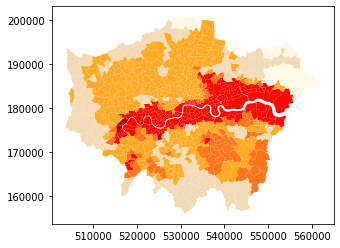

In [14]:
gdf = gpd.read_file('shapefile/wards-river.shp')
gdf['colour'] = col
fig, ax = plt.subplots(1, 1)
gdf.plot(color=gdf['colour'], ax=ax)

In [15]:
df.drop(columns=['colour'], inplace=True)

In [16]:
#only the data
z = l+4
df_f=df.iloc[:,4:z]

In [17]:
def growth(index):
    time = list(range(0, l))
    x=np.array(time)
    y=df_f.iloc[index].to_numpy()
    #mask out NaN
    mask = ~np.isnan(x) & ~np.isnan(y)
    A = np.vstack([x, np.ones(len(x))]).T
    # linearly generated sequence
    m, c = np.linalg.lstsq(A[mask], y[mask], rcond=None)[0]
    return m, c

In [18]:
df['growth']=np.nan
df['original']=np.nan
for index, row in df.iterrows():
    if df.at[index,'Frequency'] > 1:
        m, c=growth(index)
        df.at[index, 'growth'] = m
        df.at[index, 'original'] = c    

In [19]:
df['rate_of_growth']=df['growth']/df['original']*100

In [20]:
df.to_csv("test150ct1.csv")
df.rate_of_growth.describe()

count    521.000000
mean       0.520346
std        1.087791
min       -2.109137
25%       -0.032704
50%        0.247909
75%        0.780018
max        8.601243
Name: rate_of_growth, dtype: float64

In [21]:
df.at[0,'rate_of_growth']

nan

In [22]:
x=df.sum(axis=0)
x['growth']/x['original']*100

0.5874063241077175

In [23]:
#assign colours ---- there must be an easier way....
for index, row in df.iterrows():
    x = df.at[index,'rate_of_growth']
    if (x < -2):
        df.at[index, 'colour'] = "#6e0400"
    elif (x>= -2) & (x<-1):
        df.at[index, 'colour'] = "#ad0600"
    elif (x>= -1) & (x<0):
        df.at[index, 'colour'] = "#f2cf9d"
    elif (x>0) & (x<1):
        df.at[index, 'colour'] = "#f1fc9a"
    elif (x>=1) & (x<2):
        df.at[index, 'colour'] = "#afde49"
    elif (x>=2) & (x<3):
        df.at[index, 'colour'] = "#70d636"
    elif (x!=x) or (x==0):
        df.at[index, 'colour'] = "#fffcf0"
    else:
        df.at[index, 'colour'] = "#00c410"

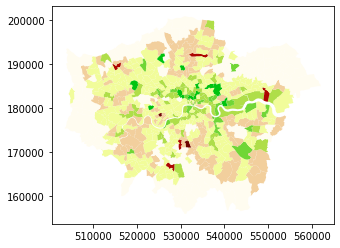

In [24]:
geodata = gpd.read_file('shapefile/wards-river.shp')
geodata['colour'] = df['colour']
fig, ax = plt.subplots(1, 1)
geodata.plot(color=geodata['colour'], ax=ax)
plt.savefig('growth2003-18no2005,new', dpi=500)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


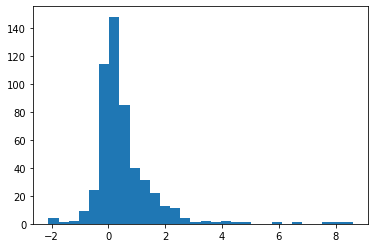

In [25]:
x = df.rate_of_growth
plt.hist(x, bins = 30)
plt.show()

In [26]:
x = df.index[df['Ward'] == "Blackwall and Cubitt Town"]
x

Int64Index([517], dtype='int64')

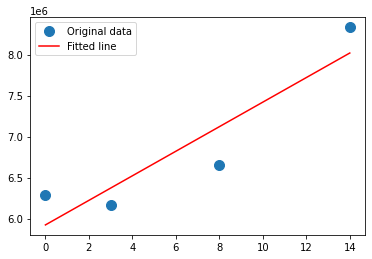

In [27]:

time = list(range(0, l))
x=np.array(time)
y=df_f.iloc[517].to_numpy()
#mask out NaN
mask = ~np.isnan(x) & ~np.isnan(y)
A = np.vstack([x, np.ones(len(x))]).T
 # linearly generated sequence
m, c = np.linalg.lstsq(A[mask], y[mask], rcond=None)[0]
m, c

plt.plot(x, y, 'o', label='Original data', markersize=10)
_ = plt.plot(x, m*x + c, 'r', label='Fitted line')
_ = plt.legend()
plt.show()

In [28]:
m/c*100

2.5279963586924765

geo = gpd.read_file('shapefile/wards-river.shp')
print(geo.crs)
geo=geo[['NAME', 'geometry']]
geodata  = geo.to_crs({'init': 'epsg:4269'})
geodata['Data']=df['rate_of_growth']
geodata

geodata['coords'] = geodata['geometry'].apply(lambda x: x.centroid.coords[:])
geodata['coords'] = [coords[0] for coords in geodata['coords']]
PALETTE = 'OrRd'
import geoplot.crs as gcrs

gplt.choropleth(geodata, hue = geodata['Data'], cmap = PALETTE, figsize = (100,100))

for _, row in geodata.iterrows():

  hue = round(row['Data'],2)
  
  plt.text(s= f'{hue:,}', x=row['coords'][0],y = row['coords'][1] - 0.01 ,
          horizontalalignment='center', fontdict = {'size': 10
                                                   })
plt.savefig('testplot.png', dpi=1)